In [1]:
import platform
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.nanops import bottleneck_switch

from Detector_Classes.M3RefTracking import M3RefTracking
from Detector_Classes.DetectorConfigLoader import DetectorConfigLoader
from Detector_Classes.DreamDetector import DreamDetector

from det_classes_test import plot_ray_hits_2d, align_dream, get_residuals, get_efficiency, get_residuals_subdets_with_err, get_rays_in_sub_det_vectorized, get_rays_in_sub_det, get_raw_residuals, get_circle_scan, plot_2D_circle_scan

In [2]:
# Check if platform is Windows or Linux
if platform.system() == 'Windows':
    base_dir = 'F:/Saclay/cosmic_data/'
    det_type_info_dir = 'C:/Users/Dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = 'F:/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dylan-MS-7C84':
    base_dir = '/media/ucla/Saclay/cosmic_data/'
    det_type_info_dir = '/home/dylan/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/media/ucla/Saclay/Analysis/Cosmic Bench/11-5-24/'
    chunk_size = 100  # Number of files to process at once
elif platform.system() == 'Linux' and platform.node() == 'dphnpct50.extra.cea.fr':
    base_dir = '/local/home/dn277127/Bureau/cosmic_data/'
    det_type_info_dir = '/local/home/dn277127/PycharmProjects/Cosmic_Bench_DAQ_Control/config/detectors/'
    out_dir = '/local/home/dn277127/Bureau/cosmic_data/Analysis/11-15-24/'
    chunk_size = 5  # Number of files to process at once
else:
    raise OSError('Unknown platform')

run_name = 'rd542_plein_1_test_9-11-25'
run_dir = f'{base_dir}{run_name}/'
sub_run_name = 'evening_test'

det_single = 'rd542_plein_1'

# file_nums = list(range(0, 49))
# file_nums = list(range(0, 109))
file_nums = 'all'

noise_sigma = 8

realign_dream = True  # If False, read alignment from file, if True, realign Dream detector

run_json_path = f'{run_dir}run_config.json'
data_dir = f'{run_dir}{sub_run_name}/filtered_root/'
ped_dir = f'{run_dir}{sub_run_name}/decoded_root/'
m3_dir = f'{run_dir}{sub_run_name}/m3_tracking_root/'
alignment_dir = f'{run_dir}alignments/'

z_align_range = [5, 5]  # mm range to search for optimal z position

try:
    os.mkdir(alignment_dir)
except FileExistsError:
    pass
try:
    os.mkdir(out_dir)
except FileExistsError:
    pass

In [3]:
print(f'Getting ray data...')
ray_data = M3RefTracking(m3_dir, single_track=True, file_nums=file_nums)

Getting ray data...


100%|██████████| 1/1 [00:00<00:00, 63.01it/s]


In [4]:
ray_data.get_xy_positions(700)

(array([  84.66364863,   31.23847858,  209.07086191, ..., -134.33159213,
          49.17724701,   66.72627075]),
 array([   3.18532968,  -21.54159489, -178.80035548, ..., -111.46955213,
          55.23508859,   36.50337984]),
 array([    7,    12,    21, ..., 11638, 11652, 11653], dtype=int32))

In [5]:
det_config_loader = DetectorConfigLoader(run_json_path, det_type_info_dir)

In [6]:
det_config = det_config_loader.get_det_config(det_single, sub_run_name=sub_run_name)
det = DreamDetector(config=det_config)
print(f'FEU Num: {det.feu_num}')
print(f'FEU Channels: {det.feu_connectors}')
print(f'HV: {det.hv}')
det.load_dream_data(data_dir, ped_dir, noise_sigma, file_nums, chunk_size, save_waveforms=False, waveform_fit_func='parabola_vectorized')
print(f'Hits shape: {det.dream_data.hits.shape}')

FEU Num: 6
FEU Channels: [1, 2, 3, 4]
HV: {'drift': 800, 'resist_1': 430, 'resist_2': 430}
Reading in data...


100%|██████████| 1/1 [00:11<00:00, 11.98s/it]


Read in data shape: (11660, 256, 32)
Getting amplitudes...


100%|██████████| 7/7 [00:01<00:00,  6.62it/s]


Fitting time: 1.1040852069854736 s
Processed sub-chunk 1/1
Processed chunk 1/1
Getting hits...
Hits shape: (11660, 256)


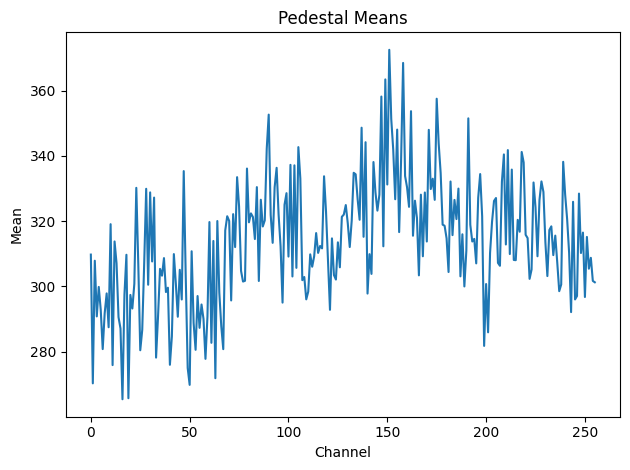

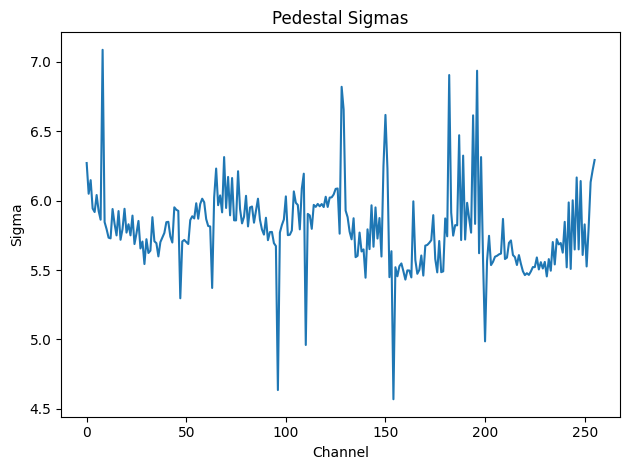

In [7]:
det.dream_data.plot_pedestals()

/local/home/dn277127/PycharmProjects/saclay_micromegas/Detector_Classes/DreamData.py:764: RuntimeWarning: All-NaN slice encountered
  event_max_amps = np.nanmax(self.data_amps, axis=1)


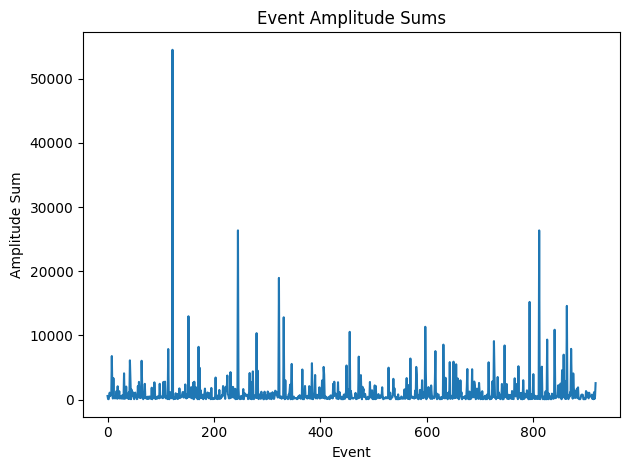

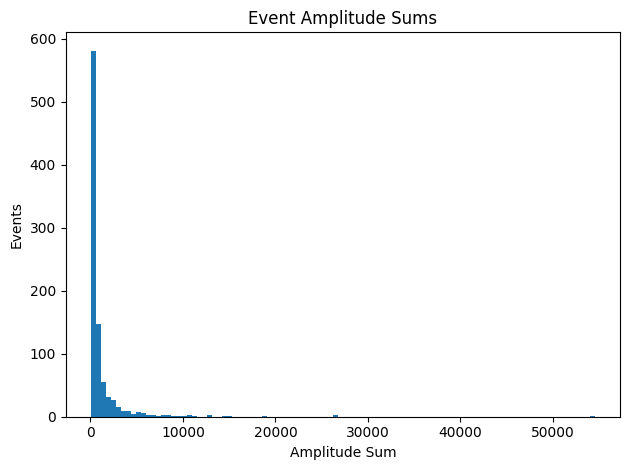

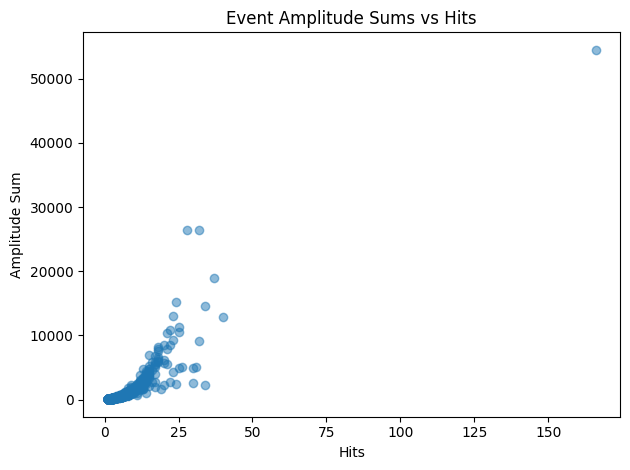

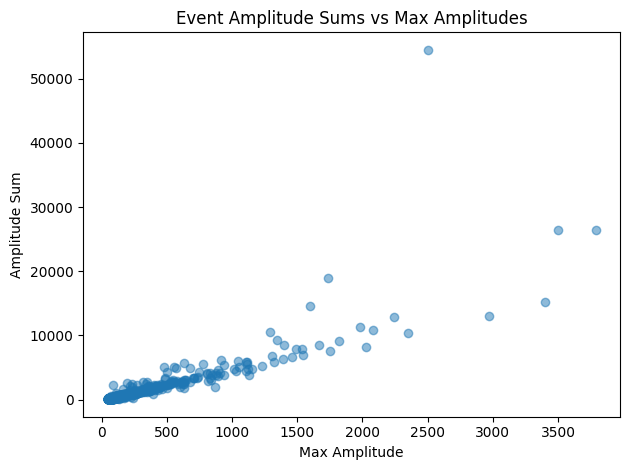

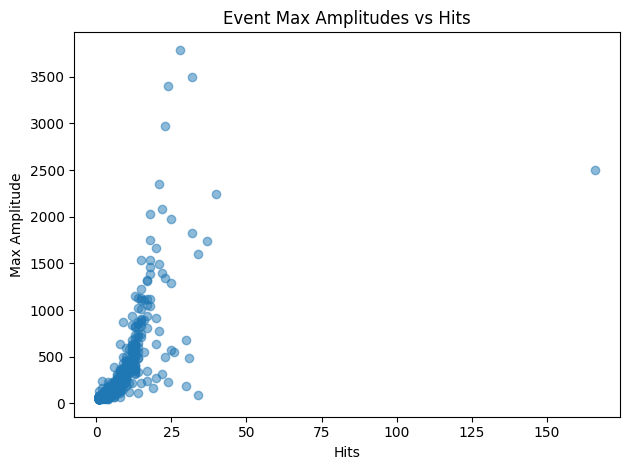

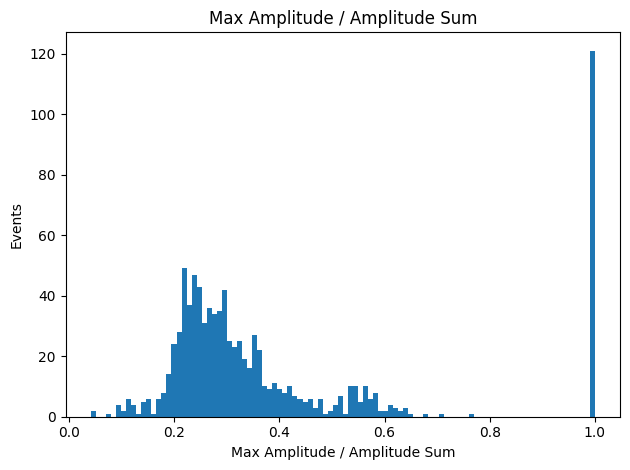

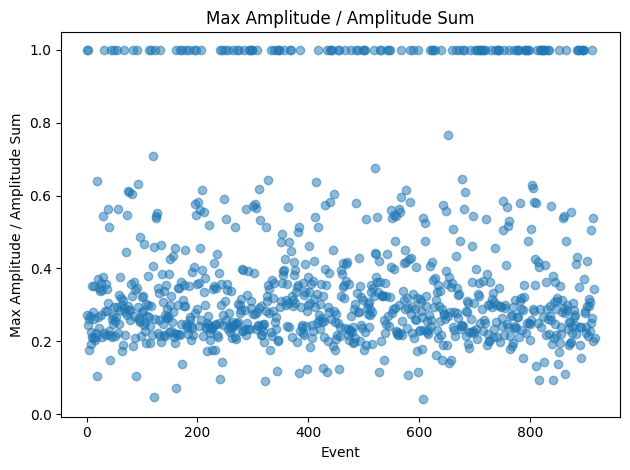

In [8]:
det.dream_data.plot_noise_metric()

Connector 1 Dead Strips: [47]
Connector 2 Dead Strips: [ 96 110]
Connector 3 Dead Strips: [128 129 130 131 154]
Connector 4 Dead Strips: [200 251 252 253]


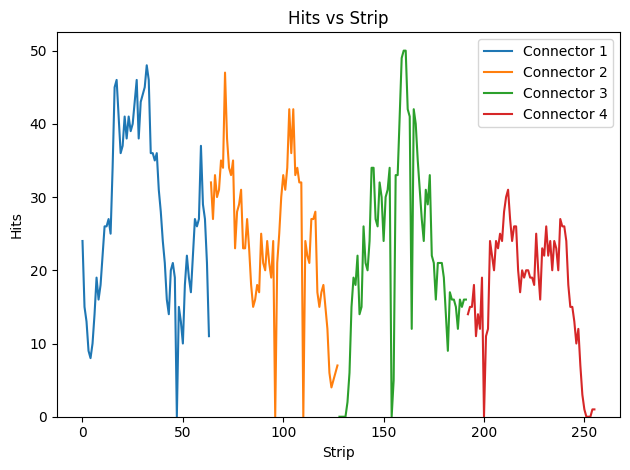

In [9]:
det.dream_data.plot_hits_vs_strip(print_dead_strips=True)

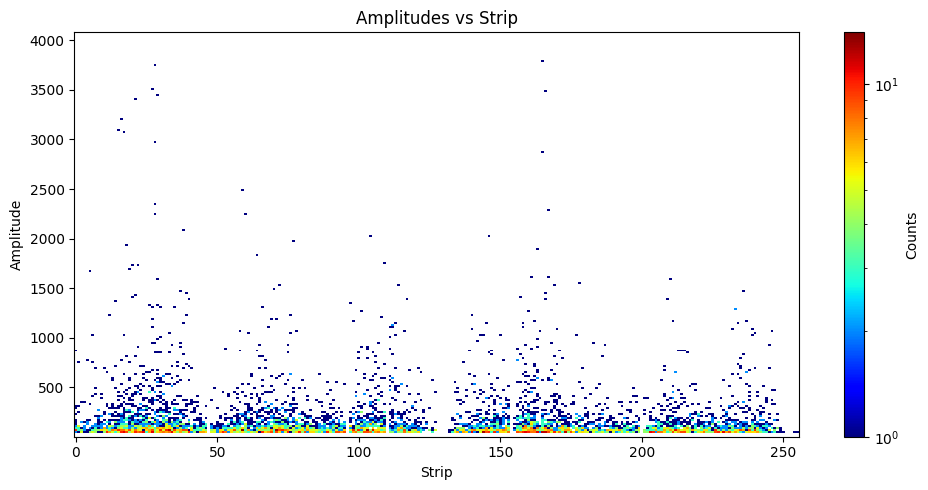

In [10]:
det.dream_data.plot_amplitudes_vs_strip()

In [11]:
print(det.det_map)

  axis pitch(mm) interpitch(mm)  connector  \
0    x       1.2          0.125          3   
1    x       1.2          0.125          4   
2    y       1.0            0.7          1   
3    y       1.0            0.7          2   

                                            channels  \
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                           xs_gerber  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...   
3  [64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71....   

                                           ys_gerber  
0  [0.0, 1.200000000000001, 2.4000000000000004, 3...  
1  [76.8, 78.0, 79.2, 80.39999999999999, 81.6, 82...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

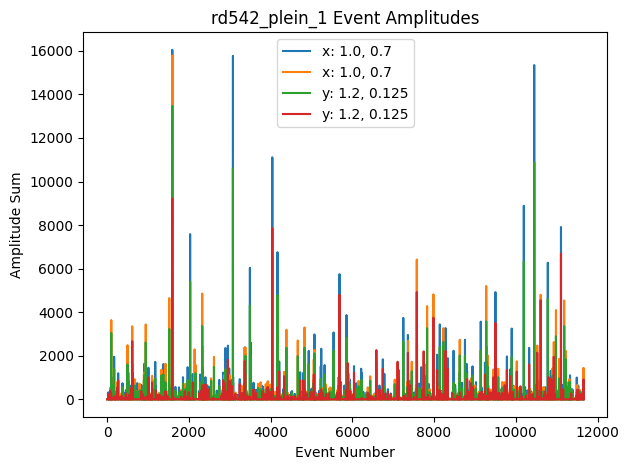

In [12]:
det.make_sub_detectors()
event_nums = det.plot_xy_amp_sum_vs_event_num(True, 500, False, 15)

if realign_dream:
    det.add_rotation(90, 'z')

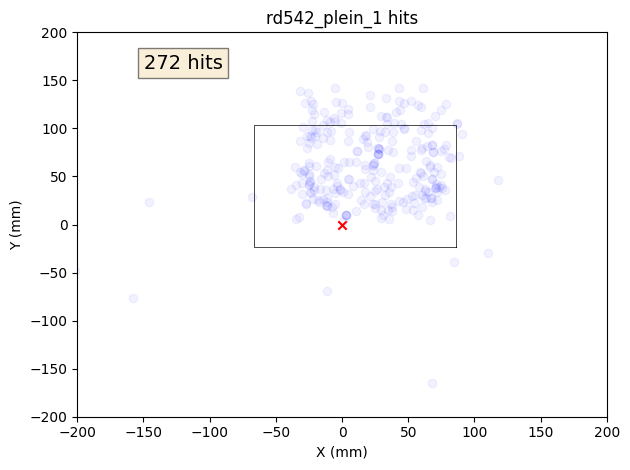

In [13]:
plot_ray_hits_2d(det, ray_data)

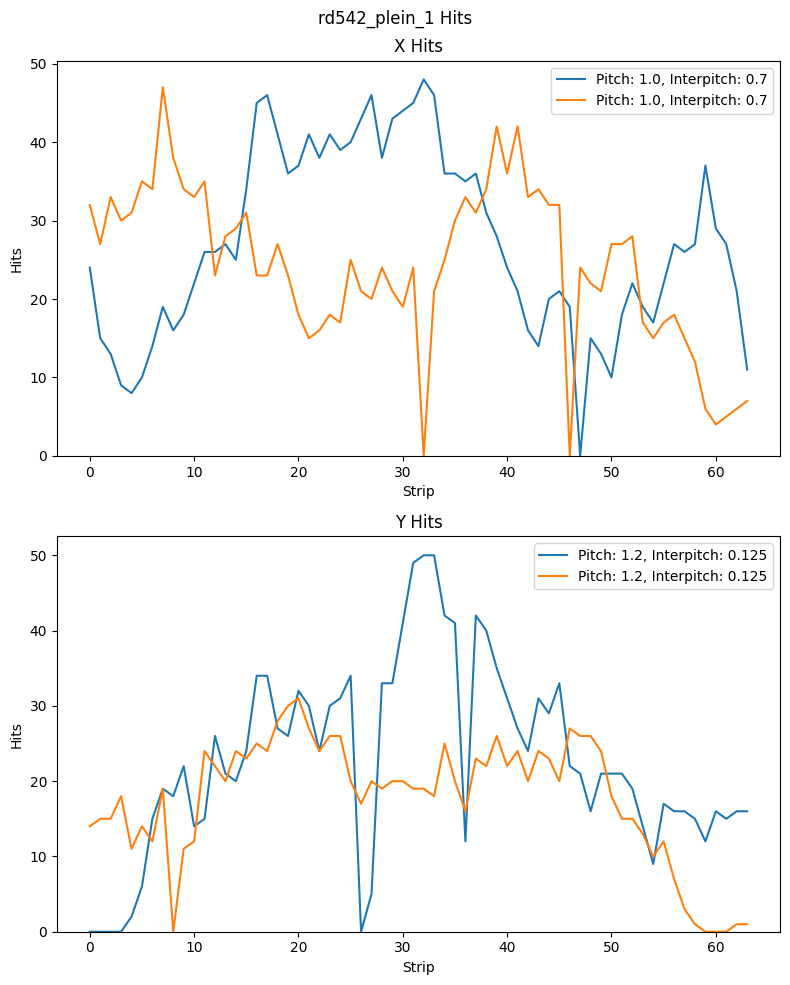

In [14]:
det.plot_hits_1d()

In [15]:
print(len(det.dream_data.hits))

11660


In [16]:
# for event_num in range(min(len(det.dream_data.hits), 2)):
#     det.plot_event_1d(event_num)
#     det.plot_event_2d(event_num)
#     det.dream_data.plot_waveforms(event_num)

z: 707.7
z: 708.0448275862069
z: 708.3896551724139
z: 708.7344827586207
z: 709.0793103448276
z: 709.4241379310346
z: 709.7689655172414
z: 710.1137931034483
z: 710.4586206896552
z: 710.8034482758621
z: 711.148275862069
z: 711.4931034482759
z: 711.8379310344828
z: 712.1827586206897
z: 712.5275862068966
z: 712.8724137931035
z: 713.2172413793104
z: 713.5620689655173
z: 713.9068965517242
z: 714.2517241379311
z: 714.596551724138
z: 714.9413793103449
z: 715.2862068965518
z: 715.6310344827587
z: 715.9758620689655
z: 716.3206896551725
z: 716.6655172413793
z: 717.0103448275862
z: 717.3551724137932
z: 717.7
z_rot: -1.0
z_rot: -0.9310344827586207
z_rot: -0.8620689655172413
z_rot: -0.7931034482758621
z_rot: -0.7241379310344828
z_rot: -0.6551724137931034
z_rot: -0.5862068965517242
z_rot: -0.5172413793103449
z_rot: -0.4482758620689655
z_rot: -0.3793103448275862
z_rot: -0.31034482758620685
z_rot: -0.24137931034482762
z_rot: -0.1724137931034483
z_rot: -0.10344827586206895
z_rot: -0.034482758620689724
z

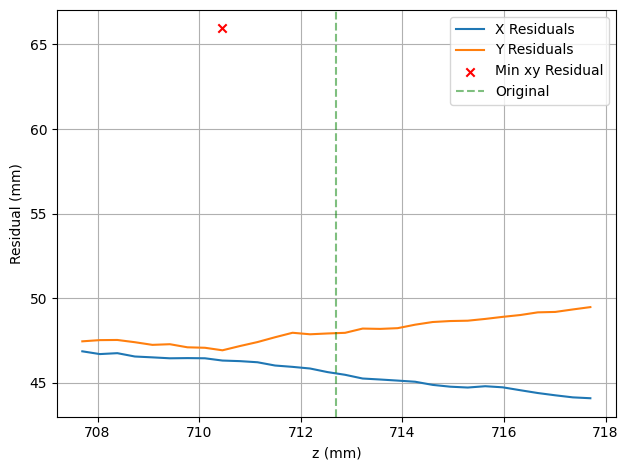

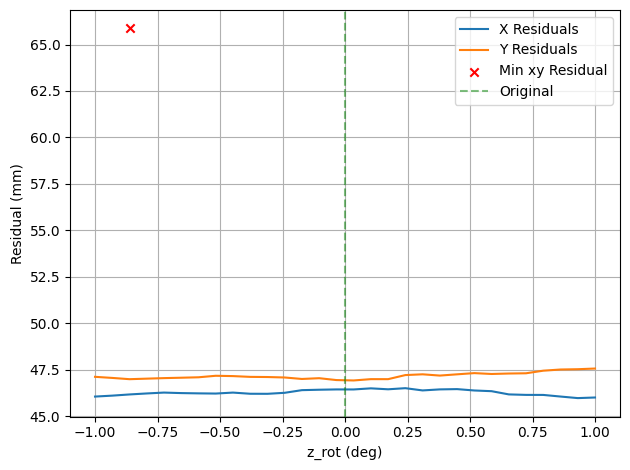

In [17]:
z_orig = det.center[2]
x_bnds = det.center[0] - det.size[0] / 2, det.center[0] + det.size[0] / 2
y_bnds = det.center[1] - det.size[1] / 2, det.center[1] + det.size[1] / 2
ray_traversing_triggers = ray_data.get_traversing_triggers(z_orig, x_bnds, y_bnds, expansion_factor=0.1)

alignment_file = f'{alignment_dir}{det.name}_alignment.txt'
if realign_dream:
    align_dream(det, ray_data, z_align_range)
    det.write_det_alignment_to_file(alignment_file)
else:
    det.read_det_alignment_from_file(alignment_file)

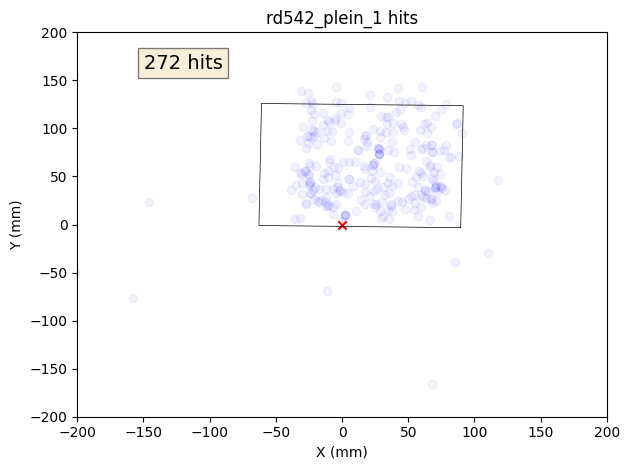

In [18]:
plot_ray_hits_2d(det, ray_data)

Pre-filtered rays: 3114
All rays: 741


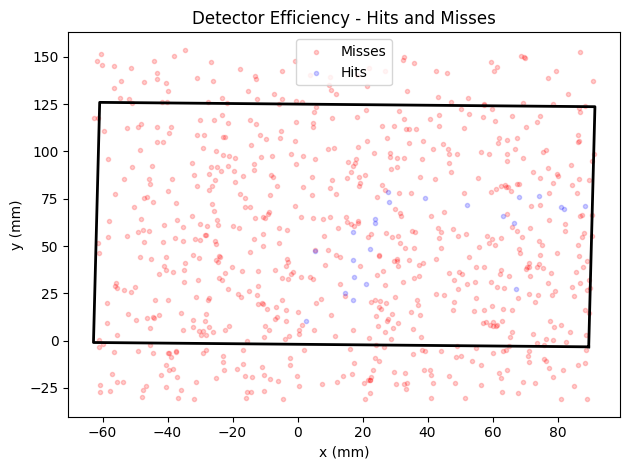

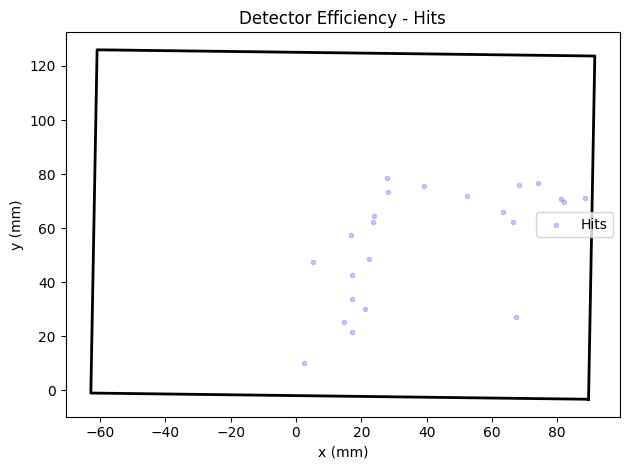

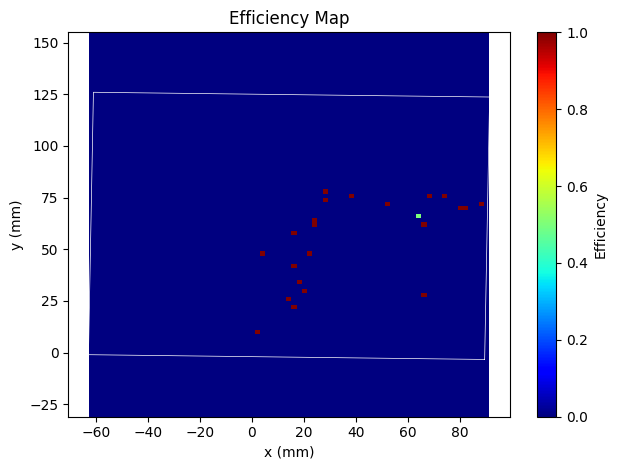

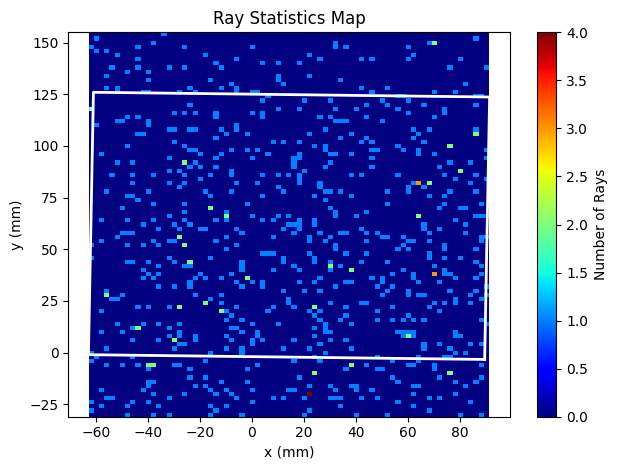

In [19]:
get_efficiency(det, ray_data, plot=True, in_det=True, tolerance=0.2, grid_size=2)

Error fitting residuals for pitch: (1.0, 1.2) mm, interpitch: (0.7, 0.125) mm
Error fitting residuals for pitch: (1.0, 1.2) mm, interpitch: (0.7, 0.125) mm


/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/local/home/dn277127/PycharmProjects/saclay_micromegas/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:210: R

Error fitting residuals for pitch: (1.0, 1.2) mm, interpitch: (0.7, 0.125) mm


(np.float64(-13.248141944091401),
 np.float64(21.49831778776546),
 np.float64(22.155965662665224),
 np.float64(12.338931669376482))

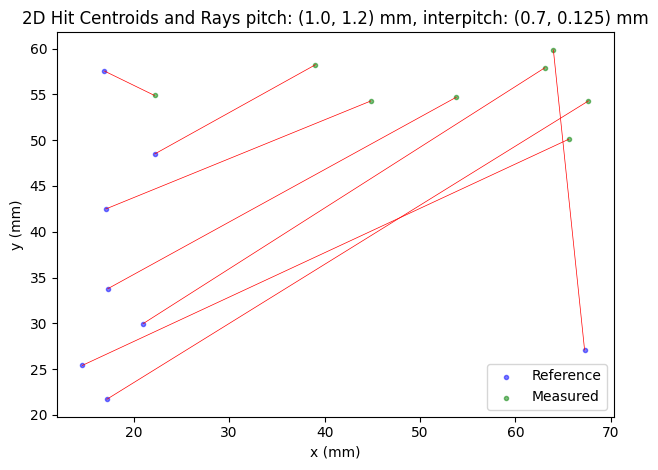

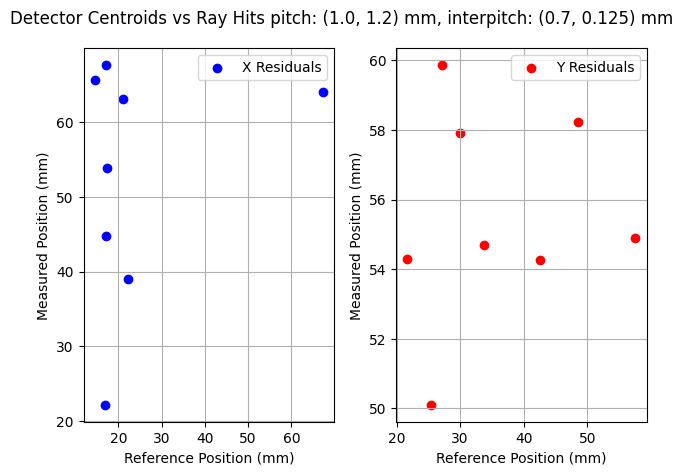

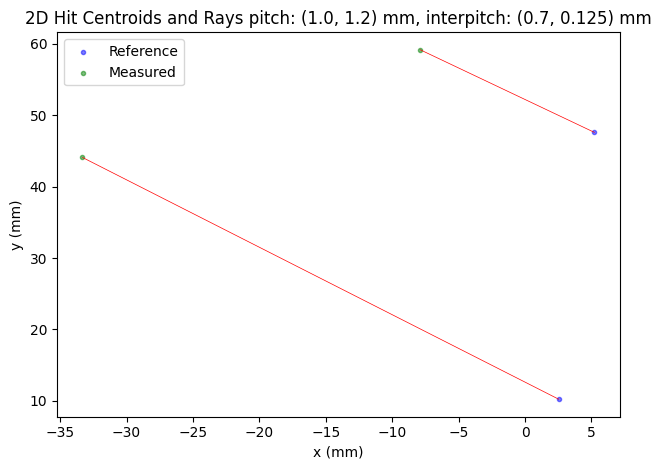

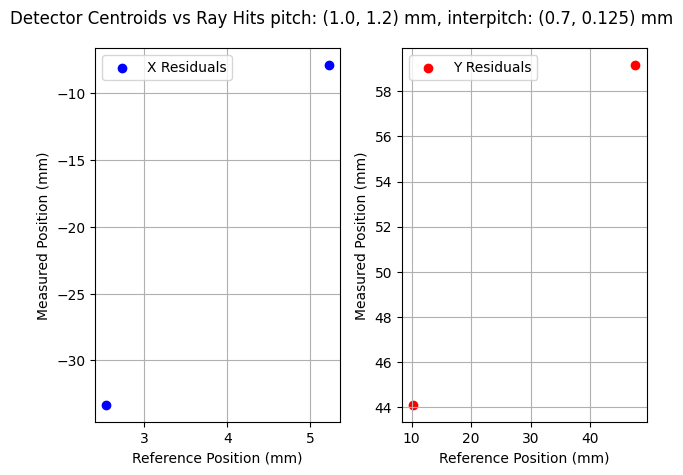

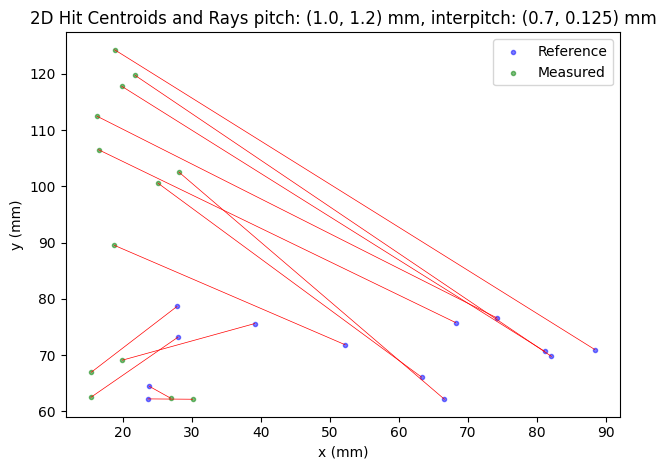

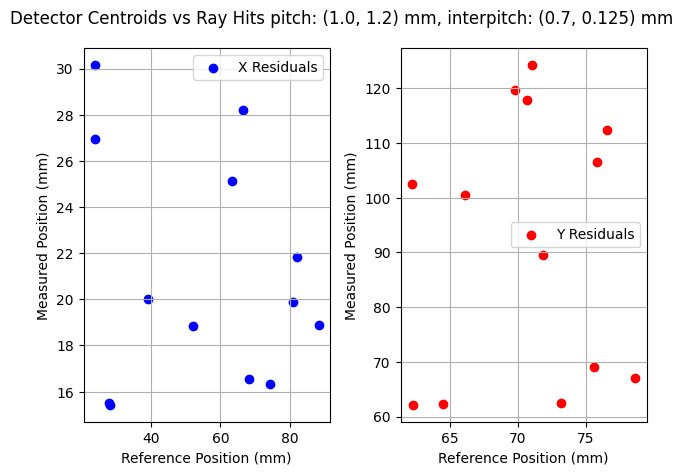

In [20]:
get_residuals(det, ray_data, plot=True, in_det=True, tolerance=0.2)

In [21]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

New stuff above

In [ ]:
sub_resids = get_residuals_subdets_with_err(det, ray_data, in_det=True, tolerance=0.2, max_r=2)
sub_resids = pd.DataFrame(sub_resids)
print(sub_resids)
fig, ax = plt.subplots()
ax.errorbar(sub_resids['interpitch_x'], sub_resids['x_std'] * 1e3, yerr=sub_resids['x_std_err'] * 1e3, fmt='o', capsize=5, label='X')
ax.errorbar(sub_resids['interpitch_x'], sub_resids['y_std'] * 1e3, yerr=sub_resids['y_std_err'] * 1e3, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Resolution (μm)')
fig.tight_layout()

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
pitches, x_means, x_errs, y_means, y_errs = [], [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=-2)
    print(f'Rays in sub-detector {sub_det.sub_index}: {len(x_rays_in)}, total rays: {len(x_rays)}')
    x_mean, y_mean, x_err, y_err = sub_det.plot_cluster_sizes(event_nums=event_num_rays_in)
    pitches.append(sub_det.x_interpitch)
    x_means.append(x_mean)
    x_errs.append(x_err)
    y_means.append(y_mean)
    y_errs.append(y_err)

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(pitches, x_means, yerr=x_errs, fmt='o', capsize=5, label='X')
ax.errorbar(pitches, y_means, yerr=y_errs, fmt='o', capsize=5, label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots()
ax.plot(pitches, x_means, 'o', label='X')
ax.plot(pitches, y_means, 'o', label='Y')
ax.legend()
ax.set_xlabel('X Strip Interpitch (mm)')
ax.set_ylabel('Cluster Size (N strips)')
fig.tight_layout()

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)

In [ ]:
scan_xs = np.linspace(-80, 60, 140 + 1)
scan_ys = np.linspace(-80, 60, 140 + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs
scan_radius = 2
min_events = 30
# res_range = [160, 810]  # μm
# mean_range = [-200, 210]  # μm
res_range = None  # μm
mean_range = None  # μm

scan_resolutions_x, scan_means_x, events_x = get_circle_scan(np.array(x_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_x, scan_means_x, scan_xs, scan_ys, scan_events=events_x, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='X (Top) Spatial Resolution', mean_title='X (Top) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_resolutions_y, scan_means_y, events_y = get_circle_scan(np.array(y_res), np.array(x_rays), np.array(y_rays), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_resolutions_y, scan_means_y, scan_xs, scan_ys, scan_events=events_y, radius=scan_radius, percentile_filter=(1, 99), conversion_factor=1e3, unit_str='μm', res_title='Y (Bottom) Spatial Resolution', mean_title='Y (Bottom) Mean Residual', res_range=res_range, mean_range=mean_range)

In [ ]:
x_res, y_res, x_rays, y_rays = get_raw_residuals(det, ray_data, in_det=True, tolerance=0.0)
scan_radius = 2
min_events = 50
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_sizes_all, y_sizes_all, x_rays_cluster_sizes, y_rays_cluster_sizes = [], [], [], []
for sub_det in det.sub_detectors:
    x_rays_in, y_rays_in, event_num_rays_in = get_rays_in_sub_det_vectorized(det, det.sub_detectors[sub_det.sub_index], x_rays, y_rays, event_num_rays, tolerance=0)
    x_sizes, y_sizes, ray_mask = sub_det.get_cluster_sizes(largest=True, event_nums=event_num_rays_in, return_ray_mask=True)
    x_sizes_all.extend(x_sizes)
    y_sizes_all.extend(y_sizes)
    x_rays_cluster_sizes.extend(x_rays_in[ray_mask])
    y_rays_cluster_sizes.extend(y_rays_in[ray_mask])
scan_resolutions_csx, scan_means_csx, events_csx = get_circle_scan(np.array(x_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csx, scan_means_csx, scan_xs, scan_ys, scan_events=events_csx, radius=scan_radius, percentile_filter=(1, 95), plot='mean', unit_str='N strips', mean_title='X Cluster Size')

In [ ]:
scan_resolutions_csy, scan_means_csy, events_csy = get_circle_scan(np.array(y_sizes_all), np.array(x_rays_cluster_sizes), np.array(y_rays_cluster_sizes), xy_pairs, radius=scan_radius, percentile_cuts=(1, 99), shape='square', gaus_fit=False, min_events=min_events, plot=False)
plot_2D_circle_scan(scan_resolutions_csy, scan_means_csy, scan_xs, scan_ys, scan_events=events_csy, radius=scan_radius, percentile_filter=(1, 99), plot='mean', unit_str='N strips', mean_title='Y Cluster Size')

In [ ]:
det.dream_data.correct_for_fine_timestamps()

sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, plot=True)
plt.title(f'Time of Max for X (Top) Strips')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips')

In [ ]:
min_amp = 600
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp}')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp}')

In [ ]:
x_rays, y_rays, event_num_rays = ray_data.get_xy_positions(det.center[2])
x_ray_angles, y_ray_angles, event_num_rays = ray_data.get_xy_angles()

in_det_mask = det.in_det_mask(x_rays, y_rays, np.full_like(x_rays, det.center[2]))

fig_x_angles, ax_x_angles = plt.subplots()
ax_x_angles.hist(np.rad2deg(x_ray_angles), bins=100)
ax_x_angles.hist(np.rad2deg(x_ray_angles[in_det_mask]), color='r', bins=100)
ax_x_angles.set_xlabel('Ray X Angles')

fig_y_angles, ax_y_angles = plt.subplots()
ax_y_angles.hist(np.rad2deg(y_ray_angles), bins=100)
ax_y_angles.hist(np.rad2deg(y_ray_angles[in_det_mask]), color='r', bins=100)
ax_y_angles.set_xlabel('Ray Y Angles')

In [ ]:
min_amp = 0
max_ray_angle = 8  # Degrees
good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
x_rays_angles_filtered, y_ray_angles_filtered = x_ray_angles[good_event_num_mask], y_ray_angles[good_event_num_mask]
ray_filter = (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) & (np.abs(y_ray_angles_filtered) < np.deg2rad(max_ray_angle))
sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=min_amp, event_filter=ray_filter, plot=True)
plt.title(f'Time of Max for X (Top) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')

sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=min_amp, event_filter=ray_filter, plot=True)
plt.title(f'Time of Max for Y (Bottom) Strips Min Amp {min_amp} & Max Ray Angle {max_ray_angle}°')

In [ ]:
min_amp = 350
angles = np.arange(2, 20, 1)  # example: 2, 4, 6, 8 degrees

sigma_x_vals, sigma_x_errs = [], []
sigma_y_vals, sigma_y_errs = [], []

for max_ray_angle in angles:
    good_event_num_mask = np.isin(event_num_rays, det.dream_data.event_nums)
    x_rays_angles_filtered = x_ray_angles[good_event_num_mask]
    y_rays_angles_filtered = y_ray_angles[good_event_num_mask]

    ray_filter = (
        (np.abs(x_rays_angles_filtered) < np.deg2rad(max_ray_angle)) &
        (np.abs(y_rays_angles_filtered) < np.deg2rad(max_ray_angle))
    )

    # --- X strips ---
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(
        max_channel=True,
        channels=np.arange(0, int(256 / 2)),
        min_amp=min_amp,
        event_filter=ray_filter,
        plot=False
    )

    sigma_x_vals.append(sigma_x)
    sigma_x_errs.append(sigma_x_err)

    # --- Y strips ---
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(
        max_channel=True,
        channels=np.arange(int(256 / 2), 256),
        min_amp=min_amp,
        event_filter=ray_filter,
        plot=False
    )

    sigma_y_vals.append(sigma_y)
    sigma_y_errs.append(sigma_y_err)

# --- summary plot ---
plt.figure()
plt.errorbar(angles, sigma_x_vals, yerr=sigma_x_errs, fmt='o-', label="X strips")
plt.errorbar(angles, sigma_y_vals, yerr=sigma_y_errs, fmt='s-', label="Y strips")
plt.xlabel("Max Ray Angle (degrees)")
plt.ylabel("σ (Time of Max)")
plt.title("σ vs Max Ray Angle")
plt.legend()
plt.show()


In [ ]:
x_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(0, int(256 / 2)), min_amp=None, filter_times=False)
x_time_maxes, x_time_filter = det.dream_data.filter_time_maxes(x_time_maxes, return_mask=True)
y_time_maxes = det.dream_data.get_event_time_maxes(max_channel=True, channels=np.arange(int(256 / 2), 256), min_amp=None, filter_times=False)
y_time_maxes, y_time_filter = det.dream_data.filter_time_maxes(y_time_maxes, return_mask=True)
time_ray_event_mask_x = np.isin(event_num_rays, det.dream_data.event_nums[x_time_filter])
time_ray_event_mask_y = np.isin(event_num_rays, det.dream_data.event_nums[y_time_filter])
x_rays_timing_x, y_rays_timing_x = x_rays[time_ray_event_mask_x], y_rays[time_ray_event_mask_x]
x_rays_timing_y, y_rays_timing_y = x_rays[time_ray_event_mask_y], y_rays[time_ray_event_mask_y]

In [ ]:
scan_radius = 2
min_events = 30
res_range = [20, 44]  # ns
mean_range = [405, 425]  # ns
scan_time_resolutions_x, scan_time_means_x, events_time_x = get_circle_scan(np.array(x_time_maxes), np.array(x_rays_timing_x), np.array(y_rays_timing_x), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_x, scan_time_means_x, scan_xs, scan_ys, scan_events=events_time_x, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution X (Top) Strips', mean_title='Mean Time X (Top) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
scan_time_resolutions_y, scan_time_means_y, events_time_y = get_circle_scan(np.array(y_time_maxes), np.array(x_rays_timing_y), np.array(y_rays_timing_y), xy_pairs, radius=scan_radius, min_events=min_events, percentile_cuts=(1, 99), shape='square', plot=False)
plot_2D_circle_scan(scan_time_resolutions_y, scan_time_means_y, scan_xs, scan_ys, scan_events=events_time_y, radius=scan_radius, percentile_filter=(1, 99), plot='both', unit_str='ns', res_title='Time Resolution Y (Bottom) Strips', mean_title='Mean Time Y (Bottom) Strips', res_range=res_range, mean_range=mean_range)

In [ ]:
channel_nums = np.arange(27, 127, 1)
min_amp = 600
time_resolutions_x, time_resolutions_errs_x = [], []
for channel_num in channel_nums:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for X (Top) Strips, Min Amp {min_amp}')
fig.tight_layout()

In [ ]:
channel_nums = np.arange(155, 256, 1)
min_amp, max_amp = 600, 3500
time_resolutions_y, time_resolutions_errs_y = [], []
for channel_num in channel_nums:
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=[channel_num], min_amp=min_amp, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(channel_nums, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5)
ax.set_xlabel('Channel Number')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution for Y (Bottom) Strips, Min Amp {min_amp}')
fig.tight_layout()

In [ ]:
min_amps = np.arange(0, 3000, 50)
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=3500, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
ax.errorbar(min_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(min_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Min Amplitude Cut')
ax.legend()
fig.tight_layout()

In [ ]:
min_amps = np.arange(0, 2600, 50)
amp_range = 50
time_resolutions_x, time_resolutions_errs_x = [], []
time_resolutions_y, time_resolutions_errs_y = [], []
for min_amp_i in min_amps:
    sigma_x, sigma_x_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(0, 128), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_x.append(sigma_x)
    time_resolutions_errs_x.append(sigma_x_err)
    sigma_y, sigma_y_err = det.dream_data.plot_event_time_maxes(max_channel=True, channels=np.arange(129, 256), min_amp=min_amp_i, max_amp=min_amp_i + amp_range, plot=False)
    time_resolutions_y.append(sigma_y)
    time_resolutions_errs_y.append(sigma_y_err)
fig, ax = plt.subplots()
mid_amps = min_amps + amp_range / 2
ax.errorbar(mid_amps, np.array(time_resolutions_x), yerr=np.array(time_resolutions_errs_x), fmt='o', capsize=5, label='X (Top) Strips')
ax.errorbar(mid_amps, np.array(time_resolutions_y), yerr=np.array(time_resolutions_errs_y), fmt='o', capsize=5, label='Y (Bottom) Strips')
ax.set_xlabel('Minimum Amplitude Cut')
ax.set_ylabel('Time Resolution (ns)')
ax.set_title(f'Time Resolution vs Amplitude ({amp_range}ns window)')
ax.legend()
fig.tight_layout()

In [ ]:
edge_cushion = 5 # mm
det_z = det.center[2]
for sub_det in det.sub_detectors:
    x_min_loc, x_max_loc = np.min(sub_det.x_pos), np.max(sub_det.x_pos)
    y_min_loc, y_max_loc = np.min(sub_det.y_pos), np.max(sub_det.y_pos)
    top_left, top_right = (x_min_loc, y_max_loc, det_z), (x_max_loc, y_max_loc, det_z)
    bottom_left, bottom_right = (x_min_loc, y_min_loc, det_z), (x_max_loc, y_min_loc, det_z)
    top_left, top_right = det.convert_coords_to_global(top_left), det.convert_coords_to_global(top_right)
    bottom_left, bottom_right = det.convert_coords_to_global(bottom_left), det.convert_coords_to_global(bottom_right)
    print(f'Sub-detector {sub_det.sub_index} corners:')
    print(f'Top Left: {top_left}, Top Right: {top_right}, Bottom Left: {bottom_left}, Bottom Right: {bottom_right}')
